# Analyzing time series

Although the Raven server by no means offer a complete suite of tools for time series analysis, we strive to provide basic algorithms that can reduce the volume of data to be downloaded and analyzed locally. To this end, Raven offers a couple of indicators based on stream flow series. 

Here. we'll test those indicators on a simple test file with around ten years of daily streamflow generated by a Raven simulation.

In [1]:
%matplotlib inline

from birdy import WPSClient
url = "http://localhost:9099/wps"
wps = WPSClient(url)#, processes='base_flow_index')

from example_data import TESTDATA
fn = str(TESTDATA['simfile_single'])

## Base flow index

The base flow index is the minimum 7-day average flow divided by the mean flow. 

In [2]:
help(wps.base_flow_index)

Help on method base_flow_index in module birdy.client.base:

base_flow_index(q=None, variable=None, freq='YS') method of birdy.client.base.WPSClient instance
    Return the base flow index, defined as the minimum 7-day average flow divided by the mean flow.
    
    Parameters
    ----------
    q : ComplexData:mimetype:`application/x-netcdf`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    variable : string
        Name of variable to analyze in netCDF file.
    freq : {'YS', 'MS', 'QS-DEC', 'AS-JUL'}string
        Resampling frequency
    
    Returns
    -------
    output : ComplexData:mimetype:`application/x-netcdf`
        The indicator values computed on the original input grid.
    output_log : ComplexData:mimetype:`text/plain`
        Collected logs during process run.



The base flow index needs as input arguments the link to a NetCDF file storing the stream flow time series, the name of the stream flow variable, and the frequency at which the index is computed (`YS`: yearly, `QS-DEC`: seasonally). 

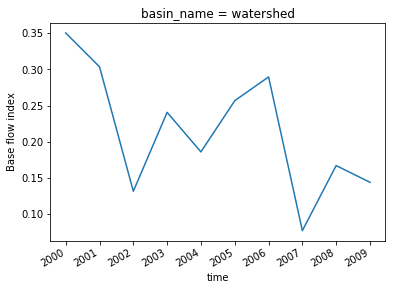

In [3]:
resp = wps.base_flow_index(fn, variable='q_sim')
out, log = resp.get(asobj=True)
out.base_flow_index.plot()

To compute generic statistics of a time series, use the `ts_stats` process.

In [4]:
help(wps.ts_stats)

Help on method ts_stats in module birdy.client.base:

ts_stats(da, op=None, variable=None, freq='YS', season=None, month=None) method of birdy.client.base.WPSClient instance
    Parameters
    ----------
    da : ComplexData:mimetype:`application/x-netcdf`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    variable : string
        Name of variable to analyze in netCDF file.
    op : {'min', 'max', 'mean', 'std', 'var', 'count', 'sum', 'argmax', 'argmin'}string
        Operation name
    freq : {'YS', 'MS', 'QS-DEC', 'AS-JUL'}string
        Resampling frequency
    season : {'DJF', 'MAM', 'JJA', 'SON'}string
        Season selection specification.
    month : {'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ...}string
        Month selection specification
    
    Returns
    -------
    output : ComplexData:mimetype:`application/x-netcdf`
        The indicator values computed on the original input grid.
    output_log : ComplexData:mimetype:`text/plain`
        

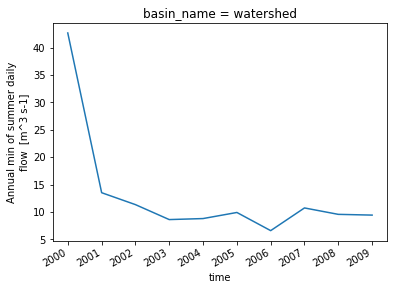

In [5]:
# Here we compute the annual summer (JJA) minimum
resp = wps.ts_stats(fn, variable='q_sim', op='min', season='JJA')
out, log = resp.get(asobj=True)
out.ts_stats.plot()

## Frequency analysis

The process `freq_analysis` is similar to the previous stat sin the it fits a series of annual maxima or minima to a statistical distribution, and returns the values corresponding to different return periods. 

In [6]:
help(wps.freq_analysis)

Help on method freq_analysis in module birdy.client.base:

freq_analysis(da, mode, t, dist=None, variable=None, window=1, freq=None, season=None, month=None) method of birdy.client.base.WPSClient instance
    Parameters
    ----------
    da : ComplexData:mimetype:`application/x-netcdf`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    variable : string
        Name of variable to analyze in netCDF file.
    mode : {'min', 'max'}string
        Mode
    t : integer
        Return period
    dist : string
        Distribution
    window : integer
        Window size
    freq : {'YS', 'MS', 'QS-DEC', 'AS-JUL'}string
        Resampling frequency
    season : {'DJF', 'MAM', 'JJA', 'SON'}string
        Season selection specification.
    month : {'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ...}string
        Month selection specification
    
    Returns
    -------
    output : ComplexData:mimetype:`application/x-netcdf`
        The indicator values computed on t

For example, computing the Q27, the minimum 7-days streamflow of reccurrence two years, can be done using the following. 

In [7]:
resp = wps.freq_analysis(fn, variable='q_sim', mode='min', t=2, dist='gumbel_r', window=7)

In [8]:
out, log = resp.get(asobj=True)
out.freq_analysis

<xarray.DataArray 'freq_analysis' (return_period: 1, nbasins: 1)>
array([[8.88304]])
Coordinates:
    basin_name     (nbasins) object ...
  * return_period  (return_period) int64 2
Dimensions without coordinates: nbasins
Attributes:
    units:          m^3 s-1
    long_name:      N-year return period min annual 7-day flow
    original_name:  
    standard_name:  discharge
    estimator:      Maximum likelihood
    cell_methods:   
    history:        [2019-06-04 14:02:42] freq_analysis(da, mode, t, dist, wi...
    mode:           min
    abstract:       
    keywords:       
    description:    Streamflow frequency analysis for the min annual 7-day fl...
    comment:        
    references:     
    notes:          
    parameters:     {'da': {'default': None, 'desc': ''}, 'mode': {'default':...

An array of return periods can be passed. 

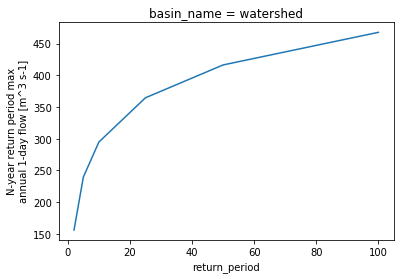

In [9]:
resp = wps.freq_analysis(fn, variable='q_sim', mode='max', t=(2, 5, 10, 25, 50, 100), dist='gumbel_r')
out, log = resp.get(asobj=True)
out.freq_analysis.plot()